In [1]:
# Bloco de importações
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.ToTensor() # Definindo a conversão de imagens para tensor para usar as bibliotecas

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # Carrega a parte de validação
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

100%|██████████| 9912422/9912422 [00:00<00:00, 79187305.95it/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19963034.58it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 17225220.04it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16725661.78it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



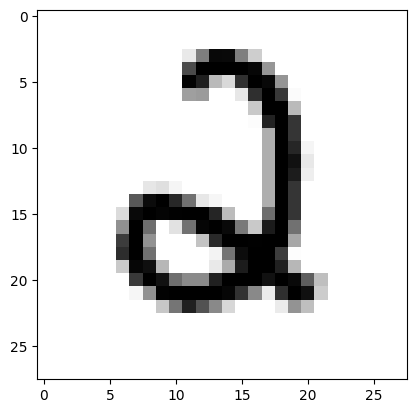

In [28]:
dataiter = iter(trainloader)
imagens, etiquetas = dataiter.__next__()
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [6]:
print(imagens[0].shape) # Verficando as dimensões do tensor de cada imagem
print(etiquetas[0].shape) # Verficando as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [21]:
# Inserindo as camadas de rede
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # Camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # Camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10) # Camada interna 2, 64 neurônios que se ligam a 10
        # para a camada saida não é mecessário definir nada pois só precisamos pegar o output da camada interna 2

    def forward(self, X):
        X = torch.as_tensor(X) # Convertendo a variável X para tensor
        X = F.relu(self.linear1(X)) # Função da ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) # Função da ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X) # Função da ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1) # Dados ultilizados para calcular a perda


In [9]:
# Função de treino
def treino(modelo, trainloader, device):

    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # Define a política de atualização dos pesos e da bias
    inicio = time() # timer para sabermos quanto tempo levou o treino

    criterio = nn.NLLLoss() # Definindo o critério para calcular a perda
    EPOCHS = 10 # Número de epochs que o algoritmo rodará
    modelo.train() # Ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0 # Inicialização da perda acumulada em questão

        for imagens, etiquetas in trainloader:

            imagens = imagens.view(imagens.shape[0], -1) # Convertendo as imagens para "vetores" de 28*28 casas para ficarem compatíveis com a
            otimizador.zero_grad() # Zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device)) # Colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # Calculando a perda de epoch em questão

            perda_instantanea.backward() # Back propagation a partir da perda

            otimizador.step() # Atualizando os pesos e as bias

            perda_acumulada += perda_instantanea.item() # Atualização da perda acumulada

        else:
            print(f'Epoch {epoch+1} - Perda restante: {perda_acumulada/len(trainloader)}')
    print('\nTempo de treino (em minutos) = ', (time()-inicio/60))

In [31]:
# Função para validar
def validacao(modelo, valloader, device):
    contas_corretas = 0
    conta_todas = 0

    for imagens, etiquetas in valloader:

        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)
            # Desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo de alto desempenho
            with torch.no_grad():
                logps = modelo(img.to(device)) # Output do modelo em escala logaritma

            ps = torch.exp(logps)
            probab = list(torch.exp(logps).numpy()[0])
            etiqueta_pred = probab.index(max(probab)) # Coverte o tensor em um número, no caso, o número que o modelo previu como correto
            etiqueta_certa = etiquetas.numpy()[i]

            if(etiqueta_certa == etiqueta_pred):
                contas_corretas += 1
            conta_todas += 1

    print(f'Total de imagens testadas: {conta_todas}')
    print(f'\nPrecisão do modelo: {contas_corretas*100 / conta_todas}%')

In [23]:
modelo = Modelo() # Modelo rede neural
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Verificando se o cuda está disponível
modelo.to(device)


Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [29]:
treino(modelo, trainloader, device)

Epoch 1 - Perda restante: 1.1772042543077266
Epoch 2 - Perda restante: 0.38014509537612706
Epoch 3 - Perda restante: 0.31646111420889905
Epoch 4 - Perda restante: 0.2767425764169393
Epoch 5 - Perda restante: 0.24627225056513033
Epoch 6 - Perda restante: 0.22022014083082614
Epoch 7 - Perda restante: 0.19936235058409318
Epoch 8 - Perda restante: 0.18174739129968417
Epoch 9 - Perda restante: 0.16649175306031508
Epoch 10 - Perda restante: 0.15360510145137304

Tempo de treino (em minutos) =  1676496666.0897708


In [32]:
validacao(modelo, valloader, device)

Total de imagens testadas: 10000

Precisão do modelo: 95.44%
